<a href="https://colab.research.google.com/github/LuciaPitarch/Colexification-Patterns/blob/main/4_Data_analysis_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This codes takes the CLICS3 colexification data as base and explores the diachronical patterns of colexification in romance and polynesian languages. 

This file is both in Python and R. 

# 0. LOAD LIBRARIES AND DATA

In [1]:
#import libraries
import pandas
import numpy as np
from collections import Counter
import itertools
import operator
import matplotlib.pyplot as plt

In [2]:
#download data
!gdown --id 1AgNMJq7hhuL2hsxrj5hGEDKfrTsNUPAF #polynesian features
!gdown --id 1xlmO2gnPnncoLjfO8-_qYm_EVAg4KSVF #romance features

Downloading...
From: https://drive.google.com/uc?id=1AgNMJq7hhuL2hsxrj5hGEDKfrTsNUPAF
To: /content/polynesian_df_features.csv
100% 317k/317k [00:00<00:00, 42.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xlmO2gnPnncoLjfO8-_qYm_EVAg4KSVF
To: /content/romance_df_features.csv
100% 348k/348k [00:00<00:00, 48.3MB/s]


In [15]:
#load the data
polynesian_df = pandas.read_csv('polynesian_df_features.csv')
romance_df = pandas.read_csv('romance_df_features.csv')

In [16]:
#merge polynesian and romance df into a single one
df = pandas.concat([polynesian_df, romance_df])

# 1. DATA OVERVIEW

In [5]:
#data summary
print(df[df['colexifies']==1].isna().sum())
print(polynesian_df.groupby('maintained').size())
print(romance_df.groupby('maintained').size())
df

Unnamed: 0                  0
Form.x                      0
clics_form                  0
Glottocode                  0
Concepticon_ID.x            0
Concepticon_Gloss.x         0
Family                      0
variety                     0
Ontological_Category.x      0
Semantic_Field.x            0
Form.y                      0
Concepticon_ID.y            0
Concepticon_Gloss.y         0
Ontological_Category.y      0
Semantic_Field.y            0
pairs                       0
maintained                  0
phonetic_pairs              0
colexifies                  0
cosine_sim                401
n_char                      0
pos.x                      87
pos.y                     142
pos_pairs                 213
pos_same                  213
path_pairs                411
wup_pairs                 411
Semantic_pairs              0
Ontological_pairs           0
dtype: int64
maintained
0.0    594
1.0    286
dtype: int64
maintained
0.0    333
1.0    616
dtype: int64


,Unnamed: 0,Form.x,clics_form,Glottocode,Concepticon_ID.x,Concepticon_Gloss.x,Family,variety,Ontological_Category.x,Semantic_Field.x,Form.y,Concepticon_ID.y,Concepticon_Gloss.y,Ontological_Category.y,Semantic_Field.y,pairs,maintained,phonetic_pairs,colexifies,cosine_sim,n_char,pos.x,pos.y,pos_pairs,pos_same,path_pairs,wup_pairs,Semantic_pairs,Ontological_pairs
0,187,*nuku,nuku,poly1242,626.0,land,Austronesian,Proto Polynesian,Person/Thing,The physical world,*nuku,2023.0,crowd,Person/Thing,Quantity,"('land', 'crowd')",0.0,1.0,1,0.084035,4.0,n,n,"('n', 'n')",1.0,0.100000,0.307692,0,1
1,210,*refu,refu,poly1242,2.0,dust,Austronesian,Proto Polynesian,Person/Thing,The physical world,*refu,646.0,ash,Person/Thing,The physical world,"('dust', 'ash')",0.0,1.0,1,0.460755,4.0,n,n,"('n', 'n')",1.0,0.125397,0.476035,1,1
2,211,*lefu,lefu,poly1242,2.0,dust,Austronesian,Proto Polynesian,Person/Thing,The physical world,*lefu,1843.0,thousand,Number,Quantity,"('dust', 'thousand')",0.0,1.0,1,0.124580,4.0,n,n,"('n', 'n')",1.0,0.076923,0.250000,0,0
3,218,*qoru,qoru,poly1242,640.0,mud,Austronesian,Proto Polynesian,Person/Thing,The physical world,*qoru,1145.0,swamp,Person/Thing,The physical world,"('mud', 'swamp')",0.0,1.0,1,0.407885,4.0,n,n,"('n', 'n')",1.0,0.081169,0.260504,1,1
4,219,*pela,pela,poly1242,640.0,mud,Austronesian,Proto Polynesian,Person/Thing,The physical world,*pela,1558.0,similar,Property,Spatial relations,"('mud', 'similar')",0.0,1.0,1,-0.001168,4.0,n,a,"('n', 'a')",0.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,942,NaN,NaN,NaN,NaN,side,NaN,NaN,NaN,NaN,NaN,NaN,fowl,NaN,NaN,"('side', 'fowl')",NaN,NaN,0,0.064977,NaN,n,n,"('n', 'n')",1.0,0.088462,0.320513,0,0
1892,943,NaN,NaN,NaN,NaN,swamp,NaN,NaN,NaN,NaN,NaN,NaN,lagoon,NaN,NaN,"('swamp', 'lagoon')",NaN,NaN,0,0.410354,NaN,n,n,"('n', 'n')",1.0,0.111111,0.333333,0,0
1893,944,NaN,NaN,NaN,NaN,fishing line,NaN,NaN,NaN,NaN,NaN,NaN,barley,NaN,NaN,"('fishing line', 'barley')",NaN,NaN,0,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,0,0
1894,945,NaN,NaN,NaN,NaN,towel,NaN,NaN,NaN,NaN,NaN,NaN,rag,NaN,NaN,"('towel', 'rag')",NaN,NaN,0,0.432502,NaN,n,n,"('n', 'n')",1.0,0.129936,0.335935,0,0


In [6]:
%load_ext rpy2.ipython

In [17]:
%%R # to run R on colab

library(dplyr)
library(readr)
library(tidyr)

polynesian_df <- read_csv('polynesian_df_features.csv')
romance_df <- read_csv('romance_df_features.csv')
df <- merge(romance_df, polynesian_df, all.x=T, all.y=T)

#set categorical data
cat_cols <- c('maintained', 'colexifies', 'pos_pairs', 'pos_same', 
              'Semantic_pairs', 'Ontological_pairs', 'Family')
df[,cat_cols] <- lapply(df[,cat_cols], as.factor)

#data overview
print(summary(df))
str(df)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  X1 = col_double(),
  Concepticon_ID.x = col_double(),
  Concepticon_ID.y = col_double(),
  maintained = col_double(),
  phonetic_pairs = col_double(),
  colexifies = col_double(),
  cosine_sim = col_double(),
  n_char = col_double(),
  pos_same = col_double(),
  path_pairs = col_double(),
  wup_pairs = col_double(),
  Semantic_pairs = col_double(),
  Ontological_pairs = col_double()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  X1 = col_double(),
  Concepticon_ID.x = col_double(),
  Concepticon_ID.y = col_double(),
  maintained = col_double(),
  phonetic_pairs = col_double(),
  colexifies = col_double(),
  cosine_sim = col_double(),
  n_char = col_double(),
  pos_same = col_double(),
  path_pairs = col_double(),
  wup_pairs = col_double(),
  

# 2. QUANTITATIVE ANALYSIS: LOGISTIC REGRESSION MODELS

 2.1. Which features predict diachronic patterns of colexification (which colexifications are loss/maintained)? 

To run this model we select just the attested colexifications as data. Then we run different logistic regression models to analyse which features better predict the loss and maintanace of colexifications. 

Now for the best model, train and test it 10 times to check for accuracy and robustness of the model

In [12]:
%%R

#logreg model
#before doing the log reg standardize variables to make them more comparable
st_vars <- c('phonetic_pairs', 'n_char', 'path_pairs', 'wup_pairs', 'cosine_sim')
df[st_vars] <- lapply(df[st_vars], function(x) c(scale(x)))

#model1:all features, loss/maintained

m1 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ phonetic_pairs+cosine_sim +n_char+pos_same+path_pairs+wup_pairs+ 
          Semantic_pairs+Ontological_pairs,
          family='binomial')
summary(m1)
#models for individual features, loss/maintained

m2 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ phonetic_pairs, 
          family='binomial')


m3 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ cosine_sim, 
          family='binomial')

m4 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ n_char, 
          family='binomial')

m5 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ pos_same, 
          family='binomial')

m6 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ path_pairs, 
          family='binomial')

m7 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ wup_pairs, 
          family='binomial')

m8 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ Semantic_pairs, 
          family='binomial')

m9 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ Ontological_pairs, 
          family='binomial')

#best model(in terms of AIC)

m10 <- glm(formula = maintained ~ phonetic_pairs + cosine_sim + path_pairs + 
    wup_pairs + Semantic_pairs + Ontological_pairs, 
    family = "binomial", 
    data = df[df$colexifies == 1, ])

print('ALL FEATURES')
print(summary(m1))
print('INDIVIDUAL MODELS')
print(summary(m2))
print(summary(m3))
print(summary(m4))
print(summary(m5))
print(summary(m6))
print(summary(m7))
print(summary(m8))
print(summary(m9))
print('BEST MODEL')
print(summary(m10))

[1] "ALL FEATURES"

Call:
glm(formula = maintained ~ phonetic_pairs + cosine_sim + n_char + 
    pos_same + path_pairs + wup_pairs + Semantic_pairs + Ontological_pairs, 
    family = "binomial", data = df[df$colexifies == 1, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2181  -0.6984   0.2194   0.6830   2.9909  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.24891    0.33232  -3.758 0.000171 ***
phonetic_pairs     -1.07707    0.12180  -8.843  < 2e-16 ***
cosine_sim          1.21766    0.10466  11.634  < 2e-16 ***
n_char             -0.03357    0.07794  -0.431 0.666668    
pos_same1           0.07097    0.32408   0.219 0.826648    
path_pairs          0.29771    0.12378   2.405 0.016160 *  
wup_pairs          -0.49060    0.14055  -3.491 0.000482 ***
Semantic_pairs1     0.59893    0.17580   3.407 0.000657 ***
Ontological_pairs1  0.36939    0.19981   1.849 0.064504 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

In [9]:
#multiple models at once
import random
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#set random seed
random.seed(10)
#fit the model with the wanted features
model = LogisticRegression()
supp_df = df.dropna()
x = supp_df[['phonetic_pairs' , 'cosine_sim' , 'path_pairs' , 
    'wup_pairs' , 'Semantic_pairs' , 'Ontological_pairs']]
y = supp_df['maintained']
model.fit(x, y)
supp_df['log_reg_prediction'] = model.predict(x)
#now lets set several train-test sets (in this case 10) to acquire a more robust model
#this way we ensure the result is not just because of the data set in the train or test model
accuracies = []
for i in range(10):
  data_train, data_test = sklearn.model_selection.train_test_split(supp_df) # defalut is 20/80
  x_train = data_train[['phonetic_pairs' , 'cosine_sim' , 'path_pairs' , 
    'wup_pairs' , 'Semantic_pairs' , 'Ontological_pairs']]
  y_train = data_train['maintained']
  x_test = data_test[['phonetic_pairs' , 'cosine_sim' , 'path_pairs' , 
    'wup_pairs' , 'Semantic_pairs' , 'Ontological_pairs']]
  y_test = data_test['maintained']
  accuracies.append(model.score(x_test, y_test))
print(accuracies)
#mean of all the accuracies
print(sum(accuracies)/10)

[0.8032786885245902, 0.8032786885245902, 0.8131147540983606, 0.839344262295082, 0.8032786885245902, 0.8360655737704918, 0.8131147540983606, 0.7704918032786885, 0.8131147540983606, 0.7868852459016393]
0.8081967213114755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


2.2 Check for crosslinguistic heterogeneity


In [10]:
%%R
clm1 <- glm(data=df[df$colexifies ==1, ], 
          maintained ~ Family+phonetic_pairs+cosine_sim +n_char+pos_same+path_pairs+wup_pairs+ 
            Semantic_pairs+Ontological_pairs,
          family='binomial')
print(summary(clm1))

clm2 <- glm(data=df[df$colexifies ==1, ], 
          maintained~Family,
          family='binomial')
print(summary(clm2))


Call:
glm(formula = maintained ~ Family + phonetic_pairs + cosine_sim + 
    n_char + pos_same + path_pairs + wup_pairs + Semantic_pairs + 
    Ontological_pairs, family = "binomial", data = df[df$colexifies == 
    1, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2185  -0.6933   0.2190   0.6736   2.9576  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.25374    0.33153  -3.782 0.000156 ***
FamilyIndo-European  0.09884    0.17607   0.561 0.574533    
phonetic_pairs      -1.05990    0.12525  -8.462  < 2e-16 ***
cosine_sim           1.21103    0.10521  11.511  < 2e-16 ***
n_char              -0.04415    0.08028  -0.550 0.582322    
pos_same1            0.04699    0.32600   0.144 0.885390    
path_pairs           0.30482    0.12386   2.461 0.013858 *  
wup_pairs           -0.49636    0.14072  -3.527 0.000420 ***
Semantic_pairs1      0.58966    0.17649   3.341 0.000835 ***
Ontological_pairs1   0.34554    0.2042

# 3. QUALITATIVE ANALYSIS

plots for every feature with percentages comparing loss/maintained and between linguistic families to further analyse what happens to colexifications trough time

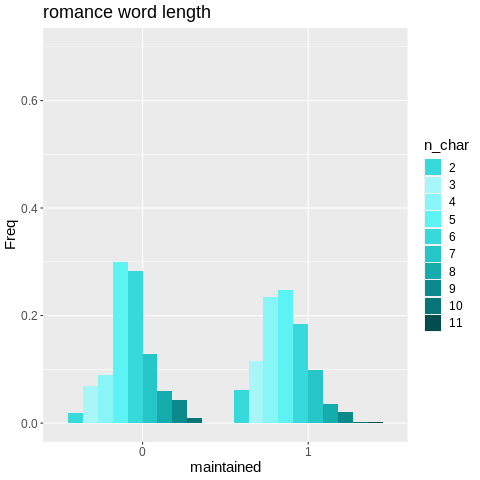

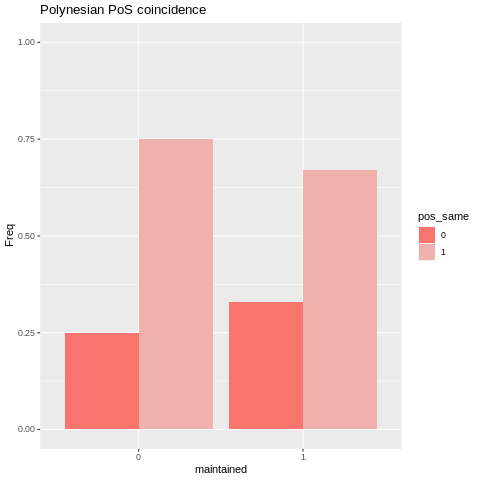

In [28]:
%%R

library(ggplot2)
#qualitative analysis
#first select just the attested colexifications and split the df into polynesian and romance
attested_colex = df[df$colexifies ==1, ]
rom_att = attested_colex[attested_colex$Family=='Indo-European',]
pol_att = attested_colex[attested_colex$Family=='Austronesian',]

#turn count data into proportions for a better comparison
#change DF, var1 and var2 and title parameters to the chosen ones (n_char, phonetic similarity, pos, ontological, semantic)
counts <- table(rom_att$maintained, rom_att$n_char, dnn=c('maintained', 'n_char'))
props <- (prop.table(counts,1))
props <- as.data.frame(props)
props <- props[0:20,]
#plot the data

red_gradient = c("#f23c30", "#f09892", "#f07b73", "#f2635a", "#f23c30",
                  "#b32b22", "#91221a", "#691913", "#400f0b", "#e3b7b3")
blue_gradient = c("#37d9db", "#a8f6f7", "#88f6f7", "#5df3f5", "#37d9db",
                  "#26c5c7", "#15acad", "#0c898a", "#077475", "#024c4d")
p1<- ggplot(props, aes(x=maintained, y=Freq, fill=n_char)) + 
  geom_col(position='dodge') +
  ylim(0.0, 0.7) +
  ggtitle('romance word length') +
  theme(text = element_text(size = 15)) 


print(p1 + scale_fill_manual(values = blue_gradient))

#plot for continuous variables(wup pairs, path pairs, cosine similarity)
p2 <- ggplot(attested_colex, aes(x=maintained, y=wup_pairs, fill=Family)) +
  geom_boxplot() +
  ylim(0.0, 1.0) +
  ggtitle('wup_pairs')
p2

#plot binary variables
pol_c <- c("#F8766D", "#F0B1AD")
rom_c <- c("#00BFC4", "#BEE9EB")
counts <- table(pol_att$maintained, pol_att$pos_same, dnn=c('maintained', 'pos_same'))
props <- (prop.table(counts,1))
props <- as.data.frame(props)
p3<- ggplot(props, aes(x=maintained, y=Freq, fill=pos_same)) + 
  geom_col(position='dodge') +
  ylim(0.0, 1.0) +
  ggtitle('Polynesian PoS coincidence')
p3 + scale_fill_manual(values = pol_c)


In [ ]:
# some data reorganization to facilitate plot creation
pol_att = polynesian_df[polynesian_df['colexifies']==1]
rom_att = romance_df[romance_df['colexifies']==1]
pol_maintained = pol_att[pol_att['maintained']==1]
pol_lost = pol_att[pol_att['maintained']==0]
rom_maintained = rom_att[rom_att['maintained']==1]
rom_lost = rom_att[rom_att['maintained']==0]
pol_list = [pol_maintained, pol_lost]
rom_list = [rom_maintained, rom_lost]

In [ ]:
#color codes to match R plots 
rom_col = ["#00BFC4", "#BEE9EB"]
pol_col = ["#F8766D", "#F0B1AD"]

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
def print_bid_plot(df_list, column, tit, col):
  """
  This function is used to plot qualitative bidirectional features
  it is used when instead of wanting to have two different counts for the tuple
  (Person/Thing, Number) and (Number, Person/Thing) we want the sum of both
  """
  dict_l = []
  labels = []
  for df in df_list:
    l = (df[column].dropna())
    count={}
    #used to count tuples and at the same time check bidirectionallity
    for i in l:
        if tuple(sorted(i)) not in count:
            count[tuple(sorted(i))]=1
        else:
            count[tuple(sorted(i))]+=1
    labels.append(get_df_name(df))
    #now turn unique values to percentages in dict
    for k in count:
      count[k]=(count[k]*100/len(l))
    # select just 10 most frequent values
    count = (dict ( sorted(count.items(), key=operator.itemgetter(1),reverse=True)))
    count=dict (itertools.islice(count.items(), 10))
    dict_l.append(count)
  #plot
  #emulate ggplot2 style
  plt.style.use('ggplot')
  supp_df = pandas.DataFrame(dict_l, index=[labels])
  supp_df = supp_df.fillna(0)
  supp_df = supp_df.astype(int, errors='ignore')
  supp_df= supp_df.T
  supp_df.plot.bar(title= tit, color=col)
  plt.ylim([0,20])

In [ ]:
def print_pos_plot(df_list, tit, col):
  #very similar to the previous function, but some parameters are adjusted to better fit pos visualization
  dict_l = []
  labels = []
  for df in df_list:
    l = (df['pos_pairs'].dropna())
    x = []
    for i in l:
      x.append(eval(i))
    count={}
    for i in x:
        if tuple(sorted(i)) not in count:
            count[tuple(sorted(i))]=1
        else:
            count[tuple(sorted(i))]+=1
    labels.append(get_df_name(df))
    #now turn unique values to percentages in dict
    for k in count:
      count[k]=(count[k]*100/len(l))
    dict_l.append(count)

  supp_df = pandas.DataFrame(dict_l, index=[labels])
  supp_df = supp_df.fillna(0)
  supp_df = supp_df.astype(int, errors='ignore')
  supp_df= supp_df.T
  supp_df.plot.bar(title= tit, color=col)
  plt.ylim([0,100])

In [ ]:
print_pos_plot(pol_list, 'PoS Polynesian', pol_col)

In [ ]:
print_bid_plot(pol_list, 'ont_ents', 'Ontological Entities Polynesian', pol_col)